In [75]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Datavis import *


In [76]:
# load data from numpy files
data = np.load('datasets/MC_data_5_14.npy')
print(data.shape)


(10000, 75)


In [77]:
syndrome = data[:, :25]
errors = data[:, 25:]
print(syndrome.shape)
print(errors.shape)



(10000, 25)
(10000, 50)


(50,)


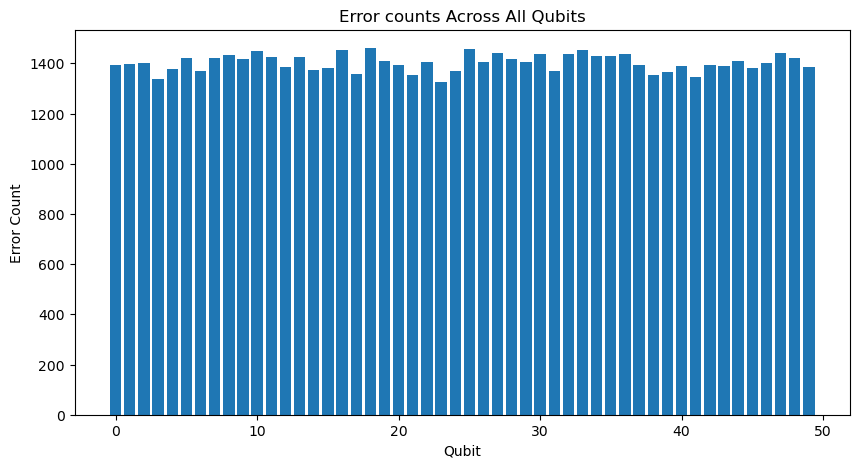

In [90]:
# data exploration
# sum all values in one column
error_counts = np.sum(errors, axis=0)
print(error_counts.shape)

plt.figure(figsize=(10, 5))
plt.title('Error counts Across All Qubits')
plt.xlabel('Qubit')
plt.ylabel('Error Count')

# plot the error counts
plt.bar(range(50), error_counts)
plt.show()


(25,)


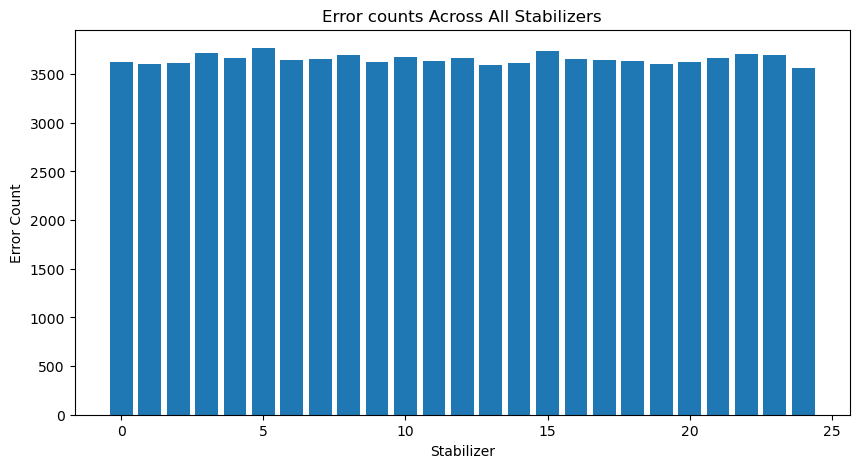

In [91]:

syndrome_counts = np.sum(syndrome, axis=0)
print(syndrome_counts.shape)

# plot syndrome counts
plt.figure(figsize=(10, 5))
plt.title('Error counts Across All Stabilizers')
plt.xlabel('Stabilizer')
plt.ylabel('Error Count')
plt.bar(range(25), syndrome_counts)
plt.show()


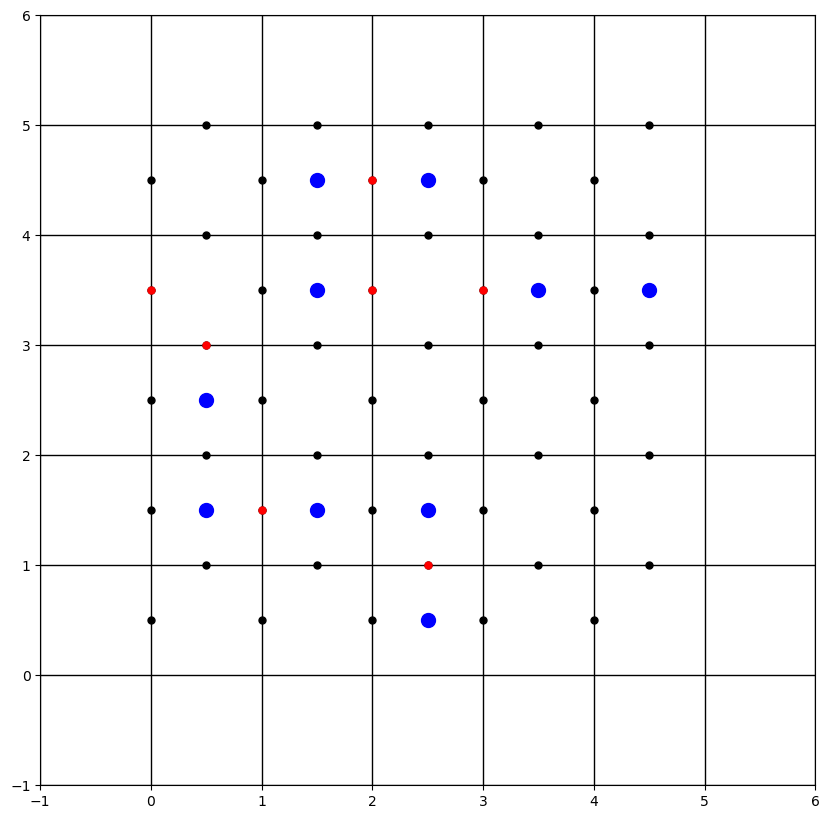

In [80]:
random_obs = np.random.randint(0, data.shape[0])
random_syndrome = syndrome[random_obs].reshape(5,5)
random_errors = errors[random_obs].reshape(10,5)

""" print(random_syndrome)
print(random_errors) """

pp_code(random_syndrome, random_errors)

In [81]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [82]:
train_data = syndrome[0:8000]
train_labels = errors[0:8000]
test_data = syndrome[8000:]
test_labels = errors[8000:]

# create multi-class classifier
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation='sigmoid')])


In [83]:

model.compile(optimizer='adam',
                #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                loss=macro_soft_f1,
                metrics=['binary_accuracy', macro_f1])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [84]:

# train model
history = model.fit(train_data, train_labels, 
                    epochs=100, 
                    batch_size=1024,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/100


2023-08-28 19:07:24.132029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.7477 - binary_accuracy: 0.5341 - macro_f1: 0.2771

2023-08-28 19:07:29.092065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 7s 470ms/step - loss: 0.7477 - binary_accuracy: 0.5341 - macro_f1: 0.2771 - val_loss: 0.7678 - val_binary_accuracy: 0.4202 - val_macro_f1: 0.2725
Epoch 2/100
7/7 [==============================] - 1s 78ms/step - loss: 0.7175 - binary_accuracy: 0.5607 - macro_f1: 0.3143 - val_loss: 0.7596 - val_binary_accuracy: 0.4091 - val_macro_f1: 0.2849
Epoch 3/100
7/7 [==============================] - 1s 84ms/step - loss: 0.7045 - binary_accuracy: 0.5730 - macro_f1: 0.3271 - val_loss: 0.7536 - val_binary_accuracy: 0.4007 - val_macro_f1: 0.2902
Epoch 4/100
7/7 [==============================] - 0s 63ms/step - loss: 0.6952 - binary_accuracy: 0.5810 - macro_f1: 0.3375 - val_loss: 0.7481 - val_binary_accuracy: 0.4217 - val_macro_f1: 0.2982
Epoch 5/100
7/7 [==============================] - 0s 41ms/step - loss: 0.6875 - binary_accuracy: 0.5883 - macro_f1: 0.3454 - val_loss: 0.7437 - val_binary_accuracy: 0.4066 - val_macro_f1: 0.2989
Epoch 6/100
7/7 [==============

63/63 - 1s - loss: 0.6422 - binary_accuracy: 0.7780 - macro_f1: 0.3675 - 1s/epoch - 23ms/step


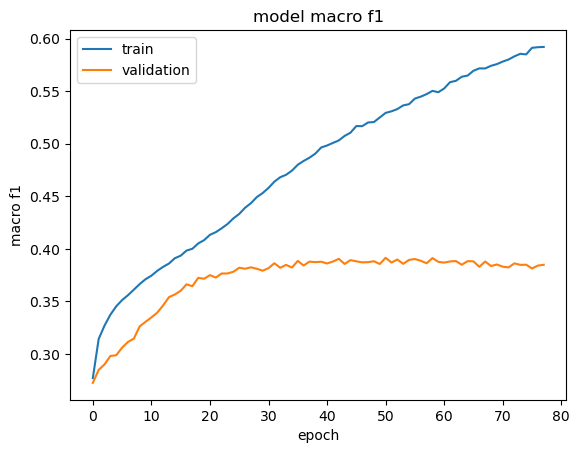

In [85]:
# evaluate model
model.evaluate(test_data, test_labels, verbose=2)

# plot macro f1
plt.plot(history.history['macro_f1'])
plt.plot(history.history['val_macro_f1'])
plt.title('model macro f1')
plt.ylabel('macro f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()




In [86]:
predictions = model.predict(test_data)


2023-08-28 19:07:49.489848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 8ms/step


664


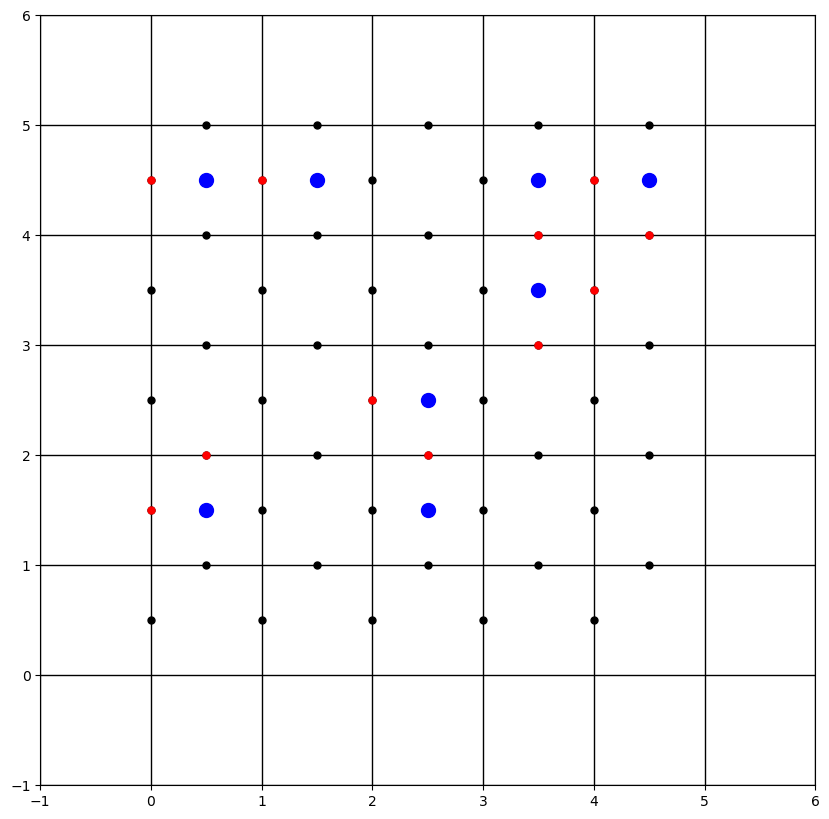

In [87]:
# random index
idx = np.random.randint(0, test_data.shape[0])
print(idx)
pred = predictions.round()[idx]

pp_code(test_data[idx].reshape(5,5), pred.reshape(10,5))

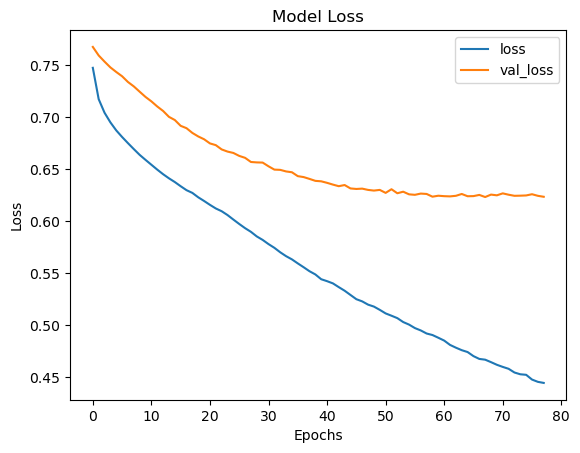

In [88]:
#plot loss and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()


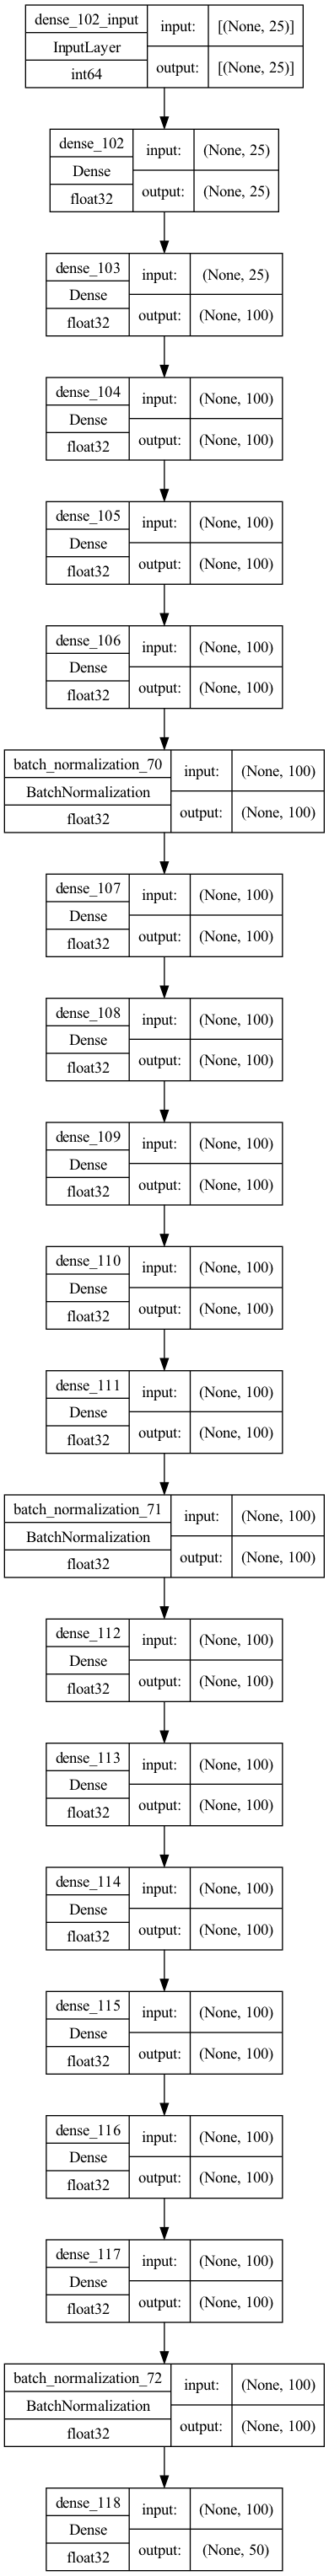

In [89]:


dot_img_file = 'mymodelname.png' #will save a file in local directory
tf.keras.utils.plot_model(model, 
 to_file=dot_img_file,
 show_dtype=True,
 expand_nested=True,
 show_layer_names=True,
 rankdir='TB',
 dpi=96,
 show_shapes=True)